## Part 1: First, make a baseline model to determine between 3's and 7's

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('/storage/data/mnist_sample')

In [3]:
# Path.BASE_PATH = path

In [4]:
# look inside of the train folder from the path to see what is located inside
(path/'train').ls()

(#2) [Path('/storage/data/mnist_sample/train/3'),Path('/storage/data/mnist_sample/train/7')]

In [5]:
# get the 3s and 7s
threes = (path/'train'/'3').ls()
threes

(#6131) [Path('/storage/data/mnist_sample/train/3/55705.png'),Path('/storage/data/mnist_sample/train/3/32379.png'),Path('/storage/data/mnist_sample/train/3/36132.png'),Path('/storage/data/mnist_sample/train/3/50201.png'),Path('/storage/data/mnist_sample/train/3/39704.png'),Path('/storage/data/mnist_sample/train/3/8475.png'),Path('/storage/data/mnist_sample/train/3/5139.png'),Path('/storage/data/mnist_sample/train/3/32610.png'),Path('/storage/data/mnist_sample/train/3/7784.png'),Path('/storage/data/mnist_sample/train/3/45704.png')...]

In [6]:
sevens = (path/'train'/'7').ls()
sevens

(#6265) [Path('/storage/data/mnist_sample/train/7/23645.png'),Path('/storage/data/mnist_sample/train/7/13644.png'),Path('/storage/data/mnist_sample/train/7/22228.png'),Path('/storage/data/mnist_sample/train/7/2229.png'),Path('/storage/data/mnist_sample/train/7/6064.png'),Path('/storage/data/mnist_sample/train/7/24505.png'),Path('/storage/data/mnist_sample/train/7/26356.png'),Path('/storage/data/mnist_sample/train/7/19987.png'),Path('/storage/data/mnist_sample/train/7/19592.png'),Path('/storage/data/mnist_sample/train/7/49413.png')...]

In [7]:
# exmaine one of the images
example_seven = Image.open(sevens[0])
example_seven

## Build the baseline model that makes the average 3/7

In [8]:
# convert the urls into a list of tensors
threes_tensor_list = [tensor(Image.open(three_path)) for three_path in threes]


In [9]:
sevens_tensor_list = [tensor(Image.open(seven_path)) for seven_path in sevens]

In [10]:
# stack the tensors to create a single 3D tensor
threes_tensor = torch.stack(threes_tensor_list)/255
threes_tensor_2 = torch.stack(threes_tensor_list).float()/255

print((threes_tensor == threes_tensor_2).all())

tensor(True)


In [11]:
# create single 3 and 7 tensors by stacking the list and convert the values into 0-1 range
threes_tensor = torch.stack(threes_tensor_list)/255
sevens_tensor = torch.stack(sevens_tensor_list)/255

In [12]:
# experiment with shape and dimensions in pytorch
threes_tensor.shape, threes_tensor.ndim

(torch.Size([6131, 28, 28]), 3)

<AxesSubplot:>

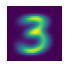

In [13]:
# to calculte the 'averaged' 3, we must take a running average through the 1st dimension (over all of the 3s)
av_3 = threes_tensor.mean(0)
show_image(av_3)

<AxesSubplot:>

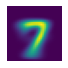

In [14]:
# do the same for the 'averaged' 7
av_7 = sevens_tensor.mean(0)
show_image(av_7)

### To predict between 3s and 7s, we must be able to compare between the current number and the ideal numbers
- Attempt to implement MAE  and RMSE manually and also using the pytorch built in error metrics

In [15]:
# manually create a mae function
def manual_mae(num_tensor, ideal_num):
    # note that due to broadcasting, num_tensor can be a 2D tensor or a 3D tensor (a tensor containing multiple image tensors) and pytorch will be able to cotinue with the computations
    # take the mean over the final 2 dimensions - the image dimensions
    return torch.mean(abs(num_tensor-ideal_num), (-2, -1))

In [16]:
# use one a single image, then use broadcasting to use on all images
manual_mae(threes_tensor[0], av_3), manual_mae(threes_tensor, av_3)

(tensor(0.1397),
 tensor([0.1397, 0.1281, 0.1542,  ..., 0.1159, 0.1253, 0.1337]))

In [17]:
# manually create rmse function
def manual_rmse(num_tensor, ideal_num):
    return torch.sqrt(torch.mean((num_tensor - ideal_num)**2, (-2, -1)))

In [18]:
manual_rmse(threes_tensor[0], av_3), manual_rmse(threes_tensor, av_3).mean()

(tensor(0.2532), tensor(0.2373))

In [19]:
pytorch_rmse = lambda num_tensor, ideal: F.mse_loss(num_tensor, ideal).sqrt()

In [20]:
pytorch_rmse(threes_tensor[0], av_3), pytorch_rmse(threes_tensor, av_3)

<ipython-input-19-fa4fa006808b>:1: UserWarning: Using a target size (torch.Size([28, 28])) that is different to the input size (torch.Size([6131, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  pytorch_rmse = lambda num_tensor, ideal: F.mse_loss(num_tensor, ideal).sqrt()


(tensor(0.2532), tensor(0.2394))

In [21]:
def is_3(input_tensor):
    return manual_rmse(input_tensor, av_3) < manual_rmse(input_tensor, av_7) 

In [22]:
# calculate the accuracy of all 3s and all 7s

acc_3 = is_3(torch.stack([tensor(Image.open(valid_3_path)) for valid_3_path in (path/'valid'/'3').ls()])/255).float().mean()
acc_3



tensor(0.9584)

In [23]:
acc_7 = (1 - is_3(torch.stack([tensor(Image.open(valid_7_path)) for valid_7_path in (path/'valid'/'7').ls()]))/255).float().mean()
acc_7

tensor(0.9997)

## Part 2: Use Gradient Descent using Pytorch on a few mathematical functions
- Write step by step what each example is doing in sgd
- Start working with a linear function
- Visualize the results

In [24]:
x_points = torch.arange(0, 20).float()
x_points

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

In [25]:
# create a function similar to a line
line_y = (5 * x_points) + 10 + torch.randn(20)
line_y

tensor([ 11.9269,  16.4873,  20.9007,  22.8945,  29.2419,  36.0783,  40.8008,  46.6806,  50.3559,  54.3134,  59.5066,  65.2415,  69.7684,  75.0418,  79.7484,  85.8599,  89.6903,  94.6043, 100.8034,
        104.3784])

In [26]:
# make a function to visualize the models we create
!pip install seaborn
import seaborn as sns

In [27]:
def graph_function(function_vals, x_vals=x_points, ax=None):
    if ax == None:
        ax = sns.scatterplot(x=x_vals, y=function_vals)
        ax.set_xlabel("X vals")
        ax.set_ylabel("Y vals")
    else:
        sns.scatterplot(x=x_vals, y=function_vals, ax=ax)
    return ax

<AxesSubplot:xlabel='X vals', ylabel='Y vals'>

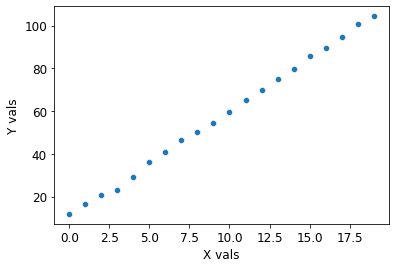

In [28]:
graph_function(line_y)

**Step 1: Initialize the parameters for the model**

In [29]:
# randomly initialize the 2 parameters for the line model (slope and y intercept)
line_model_params = torch.randn(2).requires_grad_()

**Step 2: Calculate the current predictions given by the model**

In [30]:
def get_curr_line_model(x_vals, params):
    slope, y_int = params
    curr_model_y = slope*x_vals + y_int
    return curr_model_y

In [77]:
def compare_models(curr_model, correct_model, x_vals, ax=None):
    if ax == None:
        fig, ax = plt.subplots()
    graph_function(correct_model, x_vals=x_vals, ax=ax)
    graph_function(curr_model, x_vals=x_vals, ax=ax)
    return ax


<AxesSubplot:>

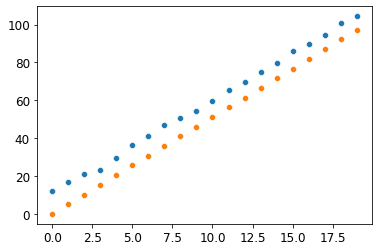

In [78]:
init_model = get_curr_line_model(x_points, line_model_params)
compare_models(init_model.detach().numpy(), line_y, x_points)

**Step 3: Calculate the loss**

In [33]:
# create a simple loss function using mae
def get_mae(temp, model):
    return (temp - model).abs().mean()

In [34]:
loss = get_mae(init_model, line_y)
loss

tensor(65.7422, grad_fn=<MeanBackward0>)

**Step 4: Calculate the gradients**

In [35]:
# use pytorch to calculate the derivatives for the loss
loss.backward()

In [36]:
line_model_params.grad

tensor([-9.5000, -1.0000])

In [37]:
line_model_params

tensor([-0.7658, -0.7506], requires_grad=True)

**Step 5: Step the weights**

In [38]:
lr = 0.01
line_model_params.data -= line_model_params.grad.data * lr
# reset the gradients after changing the model since the new gradients have changed
line_model_params.grad = None
line_model_params

tensor([-0.6708, -0.7406], requires_grad=True)

<AxesSubplot:>

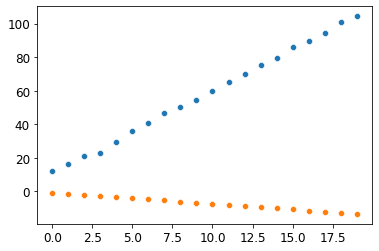

In [39]:
model_2 = get_curr_line_model(x_points, line_model_params)
compare_models(model_2.detach().numpy(), line_y, x_points)

**Convert the process into a single apply step function**

In [40]:
def apply_step(params, input_data, lr=0.01):
    # get the current model for the params
    curr_model = get_curr_line_model(x_points, params)
    # first calculate the loss
    loss = get_mae(curr_model, input_data)
    # find the gradients of the loss
    loss.backward()
    # step the loss
    params.data -= lr * params.grad.data
    
    # set the new gradients to none
    params.grad = None
    
    # return the model at the beginning of the function
    return curr_model

<AxesSubplot:>

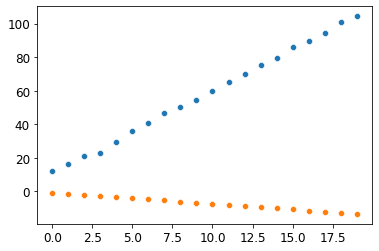

In [41]:
compare_models(apply_step(line_model_params, line_y).detach().numpy(), line_y, x_points)

**Step 6: Repeat this process multiple times**

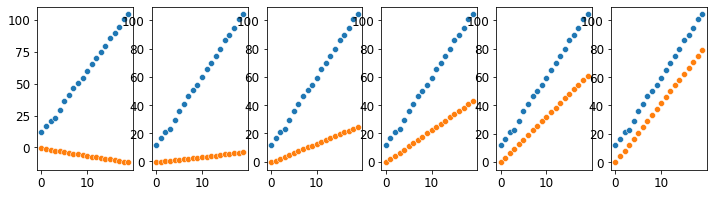

In [42]:
fig, axs = plt.subplots(1, 6, figsize=(12, 3))

for ax in axs:
    compare_models(apply_step(line_model_params, line_y, lr=0.1).detach().numpy(), line_y, x_points, ax=ax)

## Part 3: Gradient Descent with a more complicated function

In [165]:
location = torch.arange(-20, 21)
location

tensor([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
         18,  19,  20])

<AxesSubplot:xlabel='X vals', ylabel='Y vals'>

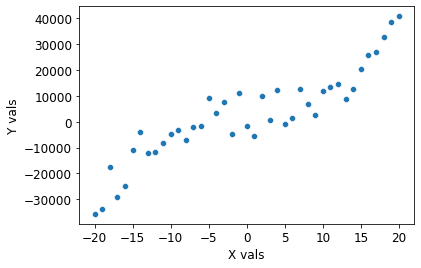

In [166]:
complex_model = 5*location**3 + 7*location**2 -1*location + torch.randn(41)*5000

graph_function(complex_model, x_vals=location)

In [167]:
# initialize the models parameters
cubic_params = torch.randn(4).requires_grad_()
cubic_params

tensor([-0.4700, -1.3253,  1.2051,  1.1527], requires_grad=True)

In [168]:
# create a function to get the results of the new model
def get_new_cubic(loc, params):
    co3, co2, co1, const = params
    return co3*(loc**3) + co2*(loc**2) + (co1*loc) + const

In [169]:
get_new_cubic(location, cubic_params)

tensor([ 3.2068e+03,  2.7235e+03,  2.2910e+03,  1.9067e+03,  1.5677e+03,  1.2711e+03,  1.0142e+03,  7.9407e+02,  6.0798e+02,  4.5309e+02,  3.2656e+02,  2.2558e+02,  1.4732e+02,  8.8982e+01,
         4.7728e+01,  2.0743e+01,  5.2063e+00, -1.7008e+00, -2.7989e+00, -9.0774e-01,  1.1527e+00,  5.6250e-01, -5.4983e+00, -1.9850e+01, -4.5311e+01, -8.4703e+01, -1.4085e+02, -2.1656e+02,
        -3.1466e+02, -4.3797e+02, -5.8932e+02, -7.7151e+02, -9.8737e+02, -1.2397e+03, -1.5314e+03, -1.8652e+03, -2.2439e+03, -2.6704e+03, -3.1475e+03, -3.6780e+03, -4.2648e+03],
       grad_fn=<AddBackward0>)

In [170]:
# create a new loss function
def rmse(preds, actual):
    return ((preds - actual)**2).mean().sqrt()

In [171]:
rmse(get_new_cubic(location, cubic_params), complex_model)

tensor(18840.9609, grad_fn=<SqrtBackward>)

In [172]:
# create a new function to apply a step
def apply_cubic_step(params, loc, lr=0.00001):
    # get the current model
    curr_cubic = get_new_cubic(loc, params)
    
    # compute the loss
    loss = rmse(curr_cubic, complex_model)
    
    # apply back propagation (calculate the gradients)
    loss.backward()
    
    # step the parameters
    params.data -= lr * params.grad.data
    
    # remove the old gradients
    params.grad = None
    
    print(loss)
    
    return curr_cubic

In [173]:
apply_cubic_step(cubic_params, location)

tensor(18840.9609, grad_fn=<SqrtBackward>)


tensor([ 3.2068e+03,  2.7235e+03,  2.2910e+03,  1.9067e+03,  1.5677e+03,  1.2711e+03,  1.0142e+03,  7.9407e+02,  6.0798e+02,  4.5309e+02,  3.2656e+02,  2.2558e+02,  1.4732e+02,  8.8982e+01,
         4.7728e+01,  2.0743e+01,  5.2063e+00, -1.7008e+00, -2.7989e+00, -9.0774e-01,  1.1527e+00,  5.6250e-01, -5.4983e+00, -1.9850e+01, -4.5311e+01, -8.4703e+01, -1.4085e+02, -2.1656e+02,
        -3.1466e+02, -4.3797e+02, -5.8932e+02, -7.7151e+02, -9.8737e+02, -1.2397e+03, -1.5314e+03, -1.8652e+03, -2.2439e+03, -2.6704e+03, -3.1475e+03, -3.6780e+03, -4.2648e+03],
       grad_fn=<AddBackward0>)

tensor(18745.0918, grad_fn=<SqrtBackward>)


<AxesSubplot:xlabel='X vals', ylabel='Y vals'>

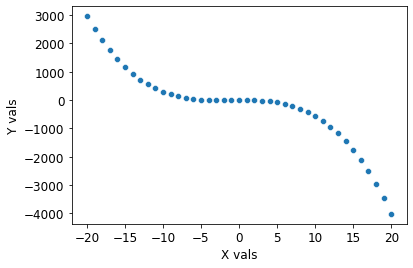

In [174]:
graph_function(apply_cubic_step(cubic_params, location).detach().numpy(), x_vals=location)

tensor(16757.3066, grad_fn=<SqrtBackward>)
tensor(16664.0059, grad_fn=<SqrtBackward>)
tensor(16570.8457, grad_fn=<SqrtBackward>)
tensor(16477.8242, grad_fn=<SqrtBackward>)
tensor(16384.9453, grad_fn=<SqrtBackward>)
tensor(16292.2109, grad_fn=<SqrtBackward>)
tensor(16199.6250, grad_fn=<SqrtBackward>)
tensor(16107.1865, grad_fn=<SqrtBackward>)
tensor(16014.9004, grad_fn=<SqrtBackward>)
tensor(15922.7656, grad_fn=<SqrtBackward>)
tensor(15830.7910, grad_fn=<SqrtBackward>)
tensor(15738.9727, grad_fn=<SqrtBackward>)
tensor(15647.3164, grad_fn=<SqrtBackward>)
tensor(15555.8232, grad_fn=<SqrtBackward>)
tensor(15464.4971, grad_fn=<SqrtBackward>)
tensor(15373.3398, grad_fn=<SqrtBackward>)
tensor(15282.3545, grad_fn=<SqrtBackward>)
tensor(15191.5430, grad_fn=<SqrtBackward>)
tensor(15100.9092, grad_fn=<SqrtBackward>)
tensor(15010.4570, grad_fn=<SqrtBackward>)
tensor(14920.1855, grad_fn=<SqrtBackward>)
tensor(14830.1016, grad_fn=<SqrtBackward>)
tensor(14740.2051, grad_fn=<SqrtBackward>)
tensor(1465

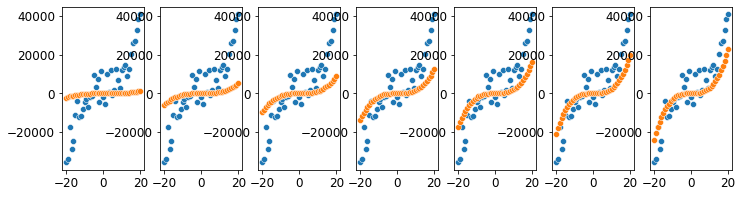

In [176]:
import math
fig, axs = plt.subplots(1, 7, figsize=(12, 3))
ITERATIONS = 100
ITER_DIV = math.floor(ITERATIONS/6)
ax_index = 0

for i in range(ITERATIONS):
    # step the model using gradient descent
    training_cubic = apply_cubic_step(cubic_params, location)
    
    # visualize some of the steps in between
    if i % ITER_DIV == 0:
#         print(i, ITER_DIV)
#         print(training_quartic)
#         print()
        compare_models(training_cubic.detach().numpy(), complex_model, location, ax=axs[ax_index])
        ax_index += 1

